# DEFINITION OF FUNCTIONS
* For plotting a map

In [1]:
def plot_map(X, Y, data, title, xlabel, ylabel, title_colorbar, path_save, title_save):
        '''
        Function for plotting a map.
        
        Args :  
        X, Y, data, title, xlabel, ylabel, title_colorbar, path_save, title_save 
        '''
        import matplotlib.pyplot as plt
        import numpy as np
            
        plt.figure()
        plt.contourf(X, Y, data, levels=np.linspace(-2,2,50))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        c=plt.colorbar()
        c.set_label(title_colorbar)
        plt.savefig(path_save + title_save)

* For plotting a map in polar projection

In [2]:
def polar_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a polar projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        # levels
        v       = cbar_levels
            
        # figure 
        fig     = plt.figure(figsize=(10,10))
        m       = Basemap(projection='ortho', lat_0=-90, lon_0=0)#, resolution="f")
        xm, ym  = m(X, Y)
        #im      = m.pcolor(xm, ym, data, cmap=cmap)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        # colorbar 
        cbar = m.colorbar(im,pad='20%')
        cbar.set_label(title_colorbar, fontsize =16)

        # structure
        m.fillcontinents(color='0.5', lake_color='0.5')
        par = m.drawparallels(np.arange(-90., -30., 20.))#,labels=[True, False, True, True])
        m.drawmeridians(np.arange(0., 360., 30.), labels=[1, 1, 1, 1]) 
        #m.drawcoastlines()
        #plt.clabel(par, inline=True, fontsize=13, fmt='%i') 

            
        plt.title(title,fontsize=18, y=1.08)
        plt.savefig(path_save + title_save, bbox_inches='tight')

* Function to interpolate bathymetry grid to my data grid in order to then create a mask for topography >= 0 with :

    etopo_interp = interp_etopo('/project_shared/ETOPO/ETOPO1_Ice_g_gmt4.grd', 'x', 'y', 'z', 1, XC, YC)

    ssh_new = np.ma.masked_where(etopo_interp>=0, mean_ssh_model)

In [3]:
def interp_etopo(tfile, lon_topo, lat_topo, z_topo, sub, lon_grid, lat_grid):
    '''
    Function to interpolate bathymetry grid to my data grid in order to then create a mask for topography >= 0 
    
    Args : tfile (file of topo/bathymetry), lon_topo, lat_topo, z_topo, sub (step used to select only part of 
    the data, lon_grid (lon of grid of our data on which we wish to interpolate topo), lat_grid (same).
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from netCDF4 import Dataset, num2date
    
    etopo = Dataset(tfile, 'r')
    lats = etopo.variables[lat_topo][::sub] # selectes lats with a step of sub (to select all choose sub = 1)
    lons = etopo.variables[lon_topo][::sub]
    z = etopo.variables[z_topo][::sub,::sub]
    if ((lons >= -180.).all() and (lons <= 180.).all()): # .all() gets rid of Falses, only keeps Trues
        lon0 = np.where(lons>=0)[0][0] # to change lons from (-180, 180) to (0, 360)
        lons = lons + 180
        topo = z.copy()
        tmp = z[0,lon0:].shape[0]
        topo[:,:tmp] = z[:,lon0:]
        topo[:,tmp:] = z[:,:lon0]
    else: 
        topo = z.copy()

    grid = interpolate.interp2d(lons, lats, topo, kind='linear') # interpolates the topo to the grid of the data
    lon, lat = lon_grid, lat_grid
    etopo_interp = grid(lon, lat)
    return etopo_interp

In [4]:
# Functions to save and load variables/data

def pickle_save(name, path, data, verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)
    full_name = (os.path.join(path,name+ '.npy'))


    with open(full_name, 'wb') as f2:
        pickle.dump(data, f2)
    if verbose:
        print('saved at : ',full_name)

def pickle_load(name, path, verbose=True):
    #if not os.path.exists(path):
    #    os.makedirs(path)
    full_name= (os.path.join(path,name+ '.npy'))

    with open(full_name, 'r') as f:
        data=pickle.load(f)

    if verbose:
        print('loaded from : ',full_name)
    return data

In [5]:
def lambert_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(8,8))
        m       = Basemap(llcrnrlon=lon[0],llcrnrlat=lat[0],urcrnrlon=lon[-1],urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=70.,lon_0=-185.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='0.5', lake_color='0.5')
        m.drawparallels(np.arange(-80.,-60.,5), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(160.,210.,5), labels=[0, 0, 0, 1])
        m.drawcoastlines()



        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

***

# CODE

* Loads data
* Calculates variables

In [6]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import h5py
from scipy.io import loadmat
from mpl_toolkits.basemap import Basemap
import netCDF4
from scipy import interpolate
import os
import pickle

plot_path_1993_2017='/home/ebent/plots/1993_2017/'
plot_path_2006_2011='/home/ebent/plots/2006_2011/'
plot_path_jup='/home/ebent/plots/2006_2011/jup2/'
load_path='/data/mmazloff/AVISO/'
load_path2='/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
load_path3='/data/soccom/GRID_12/'

***

# - AVISO DATA

In [8]:
# Read data and change from .mat to numpy array
f = h5py.File(load_path + 'aviso_tot_MADT_sose_6Apr2006to5Apr2011.mat','r')

# Latitude and longitude variables
xsave = f.get('xsave')
xsave = np.array(xsave)
ysave = f.get('ysave')
ysave = np.array(ysave)

# Get rid of dimension 1 (go from 2D to 1D)
xsave = np.squeeze(xsave)
ysave = np.squeeze(ysave)

In [9]:
# Read data and change from .mat to numpy array
f = h5py.File(load_path + 'aviso_tot_MADT_sose_6Apr2006to5Apr2011.mat','r')

# Latitude and longitude variables
xsave = f.get('xsave')
xsave = np.array(xsave)
ysave = f.get('ysave')
ysave = np.array(ysave)

# Get rid of dimension 1 (go from 2D to 1D)
xsave = np.squeeze(xsave)
ysave = np.squeeze(ysave)
#ysave = ysave[:194]

# Extract of data
tsave = f.get('tsave')
tsave = np.array(tsave)
tsave = np.squeeze(tsave)
dsave = f.get('dsave')
dsave = np.array(dsave)
dsave = np.moveaxis(dsave, 2, 0)
dsave = np.moveaxis(dsave, 2, 1)

# Create grid for lat (Xa) and lon (Ya)
Xa, Ya = np.meshgrid(xsave, ysave)

# Transpose the matrices before plotting
#Xa=Xa.transpose()
#Ya=Ya.transpose()

# Calculate mean SSH
mean_ssh_a = np.nanmean(dsave, axis=0)

# Calculate de standard deviation of SSH
std_a = np.nanstd(dsave, axis=0)

AttributeError: 'module' object has no attribute 'moveaxis'

### Interpolation of bathymetry/topography on AVISO grid

In [12]:
# ETOPO file
tfile = '/project_shared/ETOPO/ETOPO1_Ice_g_gmt4.grd'

# Interpolation of bathymetry on AVISO grid
etopo_interp = interp_etopo(tfile=tfile, lon_topo='x', lat_topo='y', z_topo='z', sub=4, lon_grid=xsave, lat_grid=ysave)

<matplotlib.contour.QuadContourSet instance at 0x18d249e0>

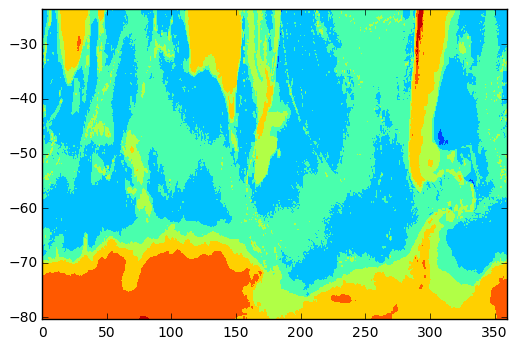

In [21]:
plt.contourf(xsave, ysave, etopo_interp)

### Land mask : creating a mask for topography >=0 thanks to the interpolation

In [38]:
# Applying a mask to the mean and std deviation matrices
mean_ssh_aviso = np.ma.masked_where(etopo_interp>=0, mean_ssh_a)
std_aviso = np.ma.masked_where(etopo_interp>=0, std_a)

### Taking into account the area of each grid cell of AVISO data

In [39]:
# Taking into account the area of each cell which increases with latitude
cell_area = 0.25*0.25*cos(ysave*pi/180)# dx*dy*cos(lat), 0.25 = 1/4 of degree --> resolution of AVISO
    
dsave2 = np.moveaxis(dsave, 2, 1)
weight = dsave2*cell_area

weight_mean_aviso = np.nansum(weight, axis=0)/(cell_area*len(tsave))
weight_mean_aviso = weight_mean_aviso.T

# LAND MASK
weight_mean_aviso = np.ma.masked_where(etopo_interp>=0, weight_mean_aviso)

## How many days of data for each grid cell ?

In [9]:
count=np.zeros((len(ysave), len(xsave)))
for t in range(len(tsave)):
    for i in range(len(ysave)):
        for j in range(len(xsave)):
            if np.isnan(dsave[t,i,j]):
                count[i,j]=count[i,j]
            else:
                count[i,j]=count[i,j]+1

count=np.ma.masked_array(count)
count=np.ma.masked_where(count==0, Count)

In [35]:
pickle_save('count', '/data/ebent', count)

('saved at : ', '/data/ebent/count.npy')


In [36]:
count = pickle_load('count', '/data/ebent')

('loaded from : ', '/data/ebent/count.npy')


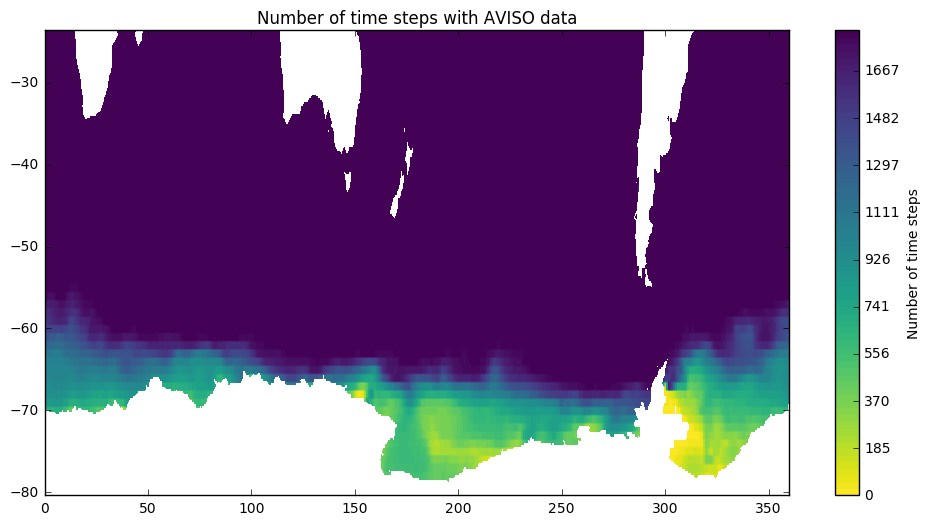

In [44]:
plt.figure(figsize=(12,6))
plt.contourf(Xa, Ya, count, levels=np.linspace(0, 1826, 70), cmap='viridis_r')
plt.title('Number of time steps with AVISO data')
c=plt.colorbar()
c.set_label('Number of time steps')
plt.savefig(plot_path_jup + 'time_steps_aviso_jup.png')

***

# - MODEL

In [9]:
# Read data as netCDF file
f = netCDF4.Dataset(load_path2+'SO12_Dec17_2005toAp2011_5day_SSH.nc','r')

# Latitude and longitude variables
XC=f.variables['XC'][:]
YC=f.variables['YC'][:]

# Extract of data
time=f.variables['time'][91:-1]
ssh=f.variables['ETAN'][91:-1]
area=f.variables['rA'][:]

# Create grid for lat (Xm) and lon (Ym)
Xm, Ym = np.meshgrid(XC, YC) 

# Calculate mean SSH
#mean_ssh_m = np.ma.mean(ssh, axis=0)

# Calculate de standard deviation of SSH
#std_m = np.ma.std(ssh, axis=0)

In [10]:
XC[0], XC[-1], YC[0], YC[-1]

(0.041666668, 359.95834, -77.991333, -30.053228)

<matplotlib.contour.QuadContourSet instance at 0x1b942710>

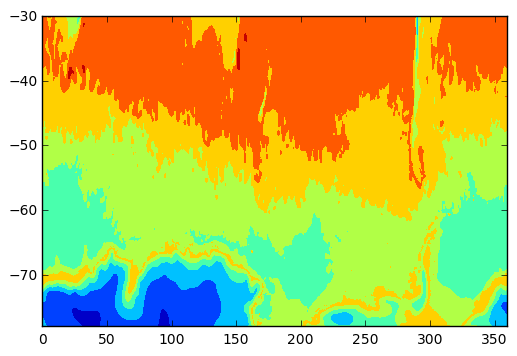

In [24]:
plt.contourf(Xm, Ym, ssh[0,...])

<matplotlib.contour.QuadContourSet instance at 0x1b70d248>

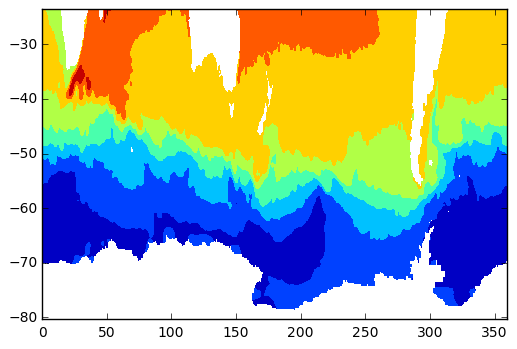

In [30]:
plt.contourf(Xa, Ya, mean_ssh_aviso)

***

## Interpolation of the whole model output on AVISO grid

Create fonction 'grid' that takes the lat and lon vectors of a data matrice and interpolates with new lat and lon when function 'grid' is called



In [42]:
ssh_interp = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for t in range(len(time)):
    gridd = interpolate.interp2d(XC, YC, ssh[t], kind='linear') # XC and YC are lat and lon vectors of model
    ssh_interp[t] = gridd(xsave, ysave)

ssh_interp is the model output interpolated to the AVISO grid

### We calculate again the new mean for SSH of model once interpolated (once plotted, looks exactly the same as mean_ssh_model and std_model)

mean_ssh_interp = np.ma.mean(ssh_interp, axis=0)
std_interp = np.ma.std(ssh_interp, axis=0)

***

# Ice mask for model

Calculate the mean of dsave (AVISO) every 5 time steps to be same size as ssh (model) and to be able to do ice mask

In [43]:
dsave_5 = np.ma.masked_all((365, len(ysave), len(xsave)))
a = 0
b = 5
for c in range(365):
    #print(c)
    #print(a,b)
    dsave_5[c]= np.nanmean(dsave[a:b], axis=0)
    a+=5
    b+=5
dsave_5[-1,:,:]=dsave_5[-2,:,:]

In [44]:
ssh_ice_mask = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for l in range(len(time)):
    ssh_ice_mask[l] = np.ma.masked_where(np.isnan(dsave_5[l]), ssh_interp[l])

In [45]:
mean_ssh_ice = np.ma.mean(ssh_ice_mask, axis=0)
std_ice = np.ma.std(ssh_ice_mask, axis=0)

***

# Land mask for the model

We extract hFacC which is the fraction of cell of water (thickness), if hFacC==0 there is no water, if hFacC==1 the cell is full of water

In [7]:
file = h5py.File(load_path3 + 'grid.mat','r')

hFacC = file.get('hFacC')
hFacC = np.array(hFacC)
Xf = file.get('XC')
Xf = np.array(Xf)
Yf = file.get('YC')
Yf = np.array(Yf)
RC = file.get('RC')
RC = np.array(RC)
z = np.squeeze(RC)

x = Xf[0,:]
y = Yf[:,0]

In [14]:
x[0], x[-1], y[0], y[-1]

(0.041666668, 359.95834, -77.991333, 2.5466681)

In [13]:
hFacC.shape, Xf.shape, Yf.shape

((104, 1260, 4320), (1260, 4320), (1260, 4320))

hFacC[0,:,:] corresponds to the layer at the surface (z = -1), we interpolate it to the AVISO grid

In [15]:
griD = interpolate.interp2d(x, y, hFacC[0,:,:], kind='linear') # XC and YC are lat and lon vectors of model
hFacC_interp = griD(xsave, ysave)

<matplotlib.contour.QuadContourSet instance at 0x194b36c8>

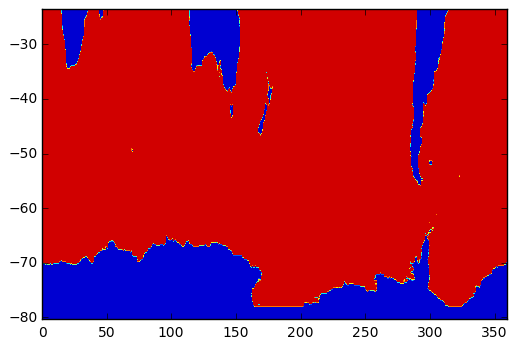

In [20]:
plt.contourf(xsave, ysave, hFacC_interp)

We apply a land mask to the model 

In [48]:
# Applying a mask to the mean and std deviation matrices
mean_ssh_model = np.ma.masked_where(hFacC_interp==0, mean_ssh_ice)
std_model = np.ma.masked_where(hFacC_interp==0, std_ice)

***

# Taking into account the area of each grid cell of model

In [49]:
# Taking into account the area of each cell which increases with latitude
weight_ssh = ssh*area

# Interpolate area to AVISO grid
griddd = interpolate.interp2d(XC, YC, area, kind='linear')
area_interp = griddd(xsave, ysave)

# Interpolate weight_ssh to AVISO grid
weight_ssh_interp = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for t in range(len(time)):
    gridd = interpolate.interp2d(XC, YC, weight_ssh[t], kind='linear') # XC and YC are lat and lon vectors of model
    weight_ssh_interp[t] = gridd(xsave, ysave)

# ICE MASK
weight_ice_mask = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for l in range(len(time)):
    weight_ice_mask[l] = np.ma.masked_where(np.isnan(dsave_5[l]), weight_ssh_interp[l])

# Calculate the mean    
weight_mean_model = np.ma.sum(weight_ssh_interp, axis=0)/(area_interp*len(time))

# LAND MASK
weight_mean_model = np.ma.masked_where(hFacC_interp==0, weight_mean_model)

***

# Save variables in netCDF files

## Model

In [60]:
nc = netCDF4.Dataset('model_enreg.nc', 'w', format='NETCDF4')
nc.title = 'Model  variables : std, mean'
from datetime import datetime
nc.date_created = datetime.now().isoformat()

nc.createDimension('lat', len(ysave))
nc.createDimension('lon', len(xsave))

std = nc.createVariable('std_model', 'f', ('lat','lon'))
std.long_name = 'Standard deviation of SSH of Model'
std[:] = std_model

mean = nc.createVariable('mean_model', 'f', ('lat','lon'))
mean.long_name = 'Mean SSH of Model'
mean[:] = mean_ssh_model

mean_weight = nc.createVariable('weight_mean_model', 'f', ('lat','lon'))
mean_weight.long_name = 'Mean SSH of Model weighted by area of each grid cell'
mean_weight[:] = weight_mean_model

nc.close()

## AVISO

In [61]:
nc = netCDF4.Dataset('aviso_enreg.nc', 'w', format='NETCDF4')
nc.title = 'AVISO variables : std, mean, Xa, Ya, count_data'
from datetime import datetime
nc.date_created = datetime.now().isoformat()

nc.createDimension('lat', len(ysave))
nc.createDimension('lon', len(xsave))
nc.createDimension('time_model', 365)

std = nc.createVariable('std_aviso', 'f', ('lat','lon'))
std.long_name = 'Standard deviation of SSH of AVISO data'
std[:] = std_aviso

mean = nc.createVariable('mean_aviso', 'f', ('lat','lon'))
mean.long_name = 'Mean SSH of AVISO data'
mean[:] = mean_ssh_aviso

mean_weight = nc.createVariable('weight_mean_aviso', 'f', ('lat','lon'))
mean_weight.long_name = 'Mean SSH of AVISO data weighted by area of each grid cell'
mean_weight[:] = weight_mean_aviso

X = nc.createVariable('Xa', 'f', ('lat','lon'))
X.long_name = 'Longitude meshgrid'
X[:] = Xa

Y = nc.createVariable('Ya', 'f', ('lat','lon'))
Y.long_name = 'Latitude meshgrid'
Y[:] = Ya


dsave_5 = nc.createVariable('dsave_5', 'f', ('time_model', 'lat', 'lon'))
dsave_5.long_name = 'AVISO selected every 5 time step to have time same size as model'
dsave_5[:] = dsave_5
'''
count_data = nc.createVariable('count', 'f', ('lat','lon'))
count_data.long_name = 'Count how many time steps of data on each grid cell'
count_data[:] = count
'''
nc.close()

# Read variables

FOR CALCULATING OFFSET : all of data (run cell bellow)

In [74]:
f1 = netCDF4.Dataset('aviso_enreg.nc', 'r', format='NETCDF4')
mean_ssh_aviso = f1.variables['mean_aviso'][:]
weight_mean_aviso = f1.variables['weight_mean_aviso'][:]
std_aviso = f1.variables['std_aviso'][:]
Ya = f1.variables['Ya'][:]
Xa = f1.variables['Xa'][:]


f2 = netCDF4.Dataset('model_enreg.nc', 'r', format='NETCDF4')
mean_ssh_model = f2.variables['mean_model'][:]
weight_mean_model = f2.variables['weight_mean_model'][:]
std_model = f2.variables['std_model'][:]

In [75]:
print(ysave[57], ysave[201], ysave[161]) # add +1 in the crop !!!!

(-66.125, -30.125, -40.125)


In [76]:
# Calculate difference between -30 and -66
diff_weight = weight_mean_aviso[57:202]-weight_mean_model[57:202]
# Calculate the offset : mean_diff
mean_diff_weight = np.nanmean(diff_weight)

In [77]:
# Calculate difference between -40 and -66
diff_weight = weight_mean_aviso[57:162]-weight_mean_model[57:162]
# Calculate the offset : mean_diff
mean_diff_weight = np.nanmean(diff_weight)

FOR PLOTTING MAPS : Read just until -40 of latitude to avoid weird red part of map that is above this lat (run cell bellow)

In [78]:
f1 = netCDF4.Dataset('aviso_enreg.nc', 'r', format='NETCDF4')
mean_ssh_aviso = f1.variables['mean_aviso'][:162,:]
weight_mean_aviso = f1.variables['weight_mean_aviso'][:162,:]
std_aviso = f1.variables['std_aviso'][:162,:]
Ya = f1.variables['Ya'][:162,:]
Xa = f1.variables['Xa'][:162,:]


f2 = netCDF4.Dataset('model_enreg.nc', 'r', format='NETCDF4')
mean_ssh_model = f2.variables['mean_model'][:162,:]
weight_mean_model = f2.variables['weight_mean_model'][:162,:]
std_model = f2.variables['std_model'][:162,:]

In [79]:
diff = mean_ssh_aviso-mean_ssh_model

# Substract both means 

In [9]:
print(ysave[201], ysave[57])

(-30.125, -66.125)


In [41]:
# Difference between mean SSH of data and model
diff = mean_ssh_aviso-mean_ssh_model
diff_weight = weight_mean_aviso[57:201]-weight_mean_model[57:201]

In [13]:
# Difference between mean SSH of data and model
diff_weight = weight_mean_aviso[57]-weight_mean_model[57]

In [42]:
# Calculate the offset : mean_diff
mean_diff_weight = np.nanmean(diff_weight)

In [44]:
diff = mean_ssh_aviso-mean_ssh_model

***

***

# PLOTS

## - AVISO data

Mean

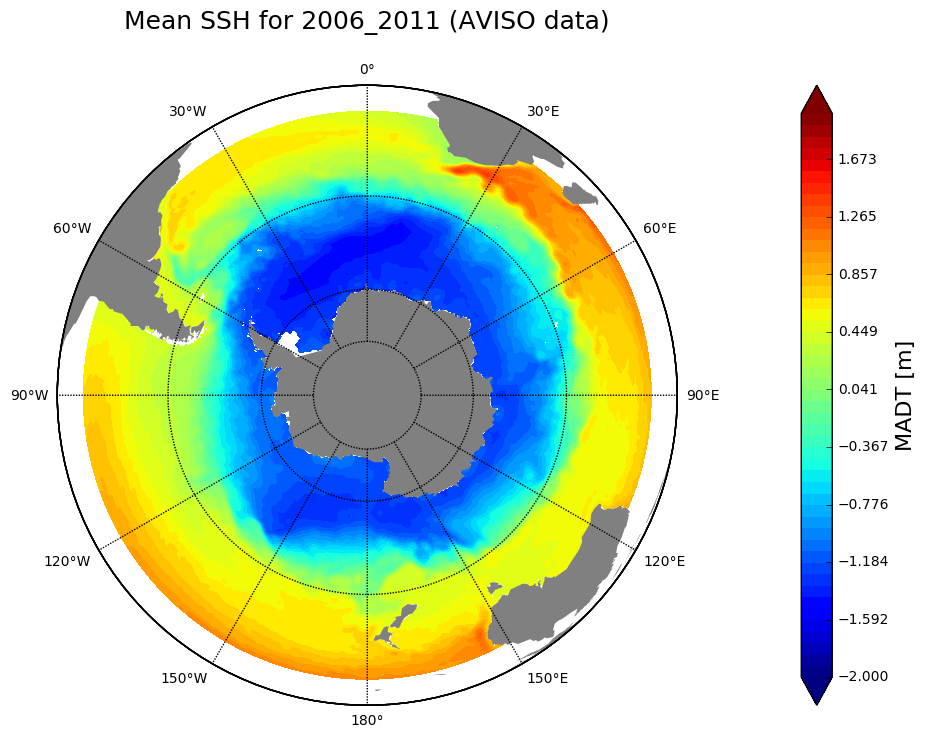

In [50]:
# Plot the mean SSH
polar_map(np.linspace(-2,2,50), Xa, Ya, mean_ssh_aviso, 'Mean SSH for 2006_2011 (AVISO data)', 'MADT [m]', plt.cm.jet, plot_path_jup, 'aviso_polar_mean_ssh_jup.png') 

Standard deviation

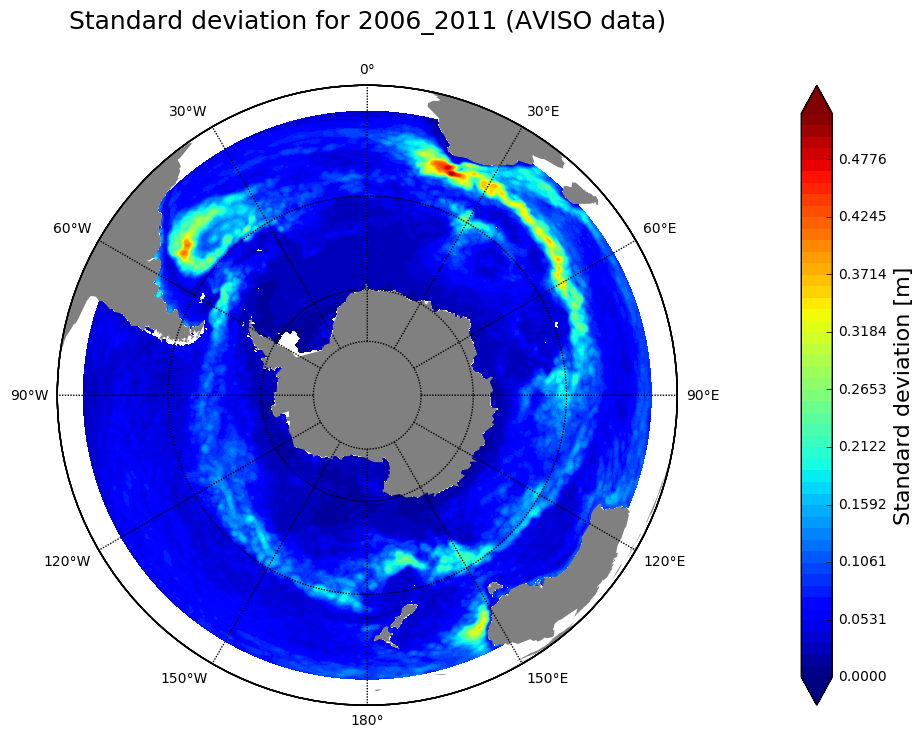

In [51]:
# Plot the standard deviation
polar_map(np.linspace(0, 0.52, 50), Xa, Ya, std_aviso, 'Standard deviation for 2006_2011 (AVISO data)', 'Standard deviation [m]', plt.cm.jet, plot_path_jup, 'aviso_std_jup.png')

## - Model

Mean

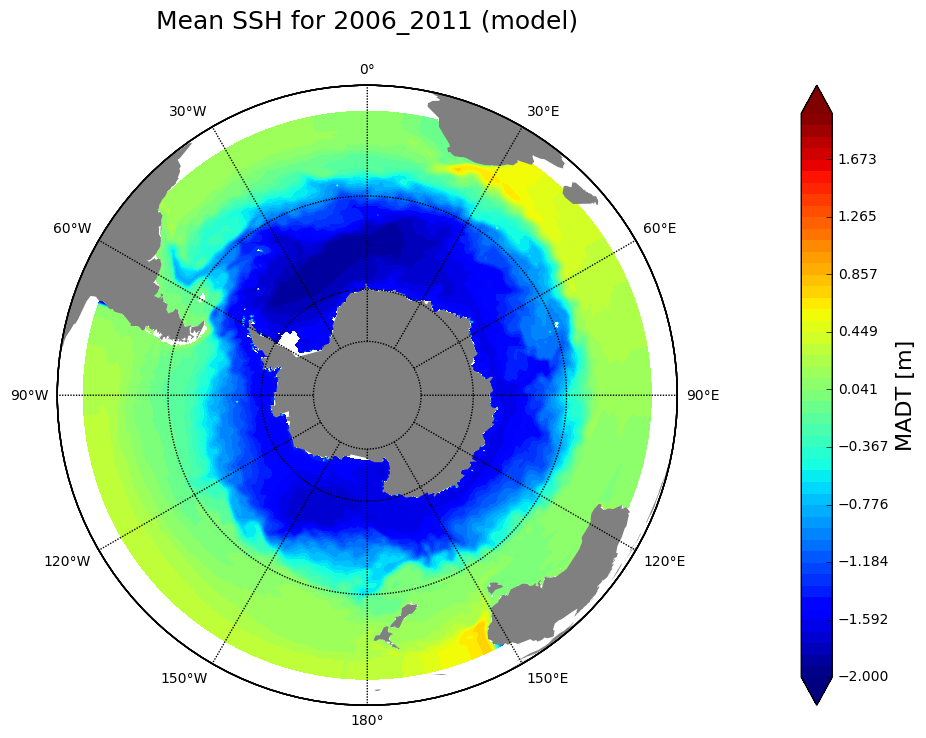

In [52]:
# Plot the mean SSH
polar_map(np.linspace(-2,2,50), Xa, Ya, mean_ssh_model, 'Mean SSH for 2006_2011 (model)', 'MADT [m]', plt.cm.jet, plot_path_jup, 'model_polar_mean_ssh_jup.png') 

Standard deviation

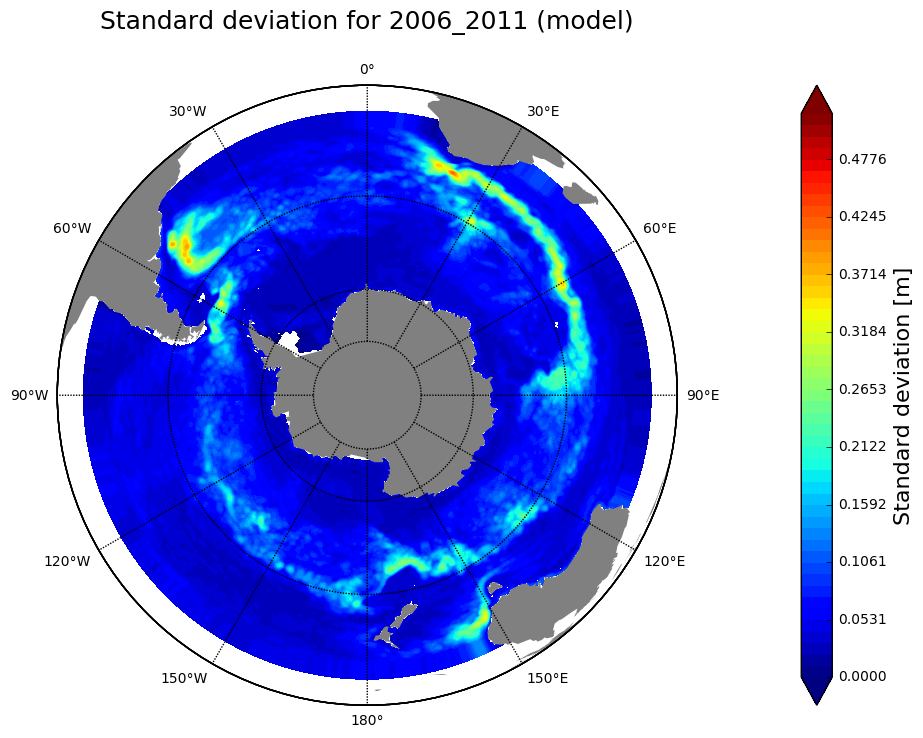

In [53]:
# Plot the standard deviation
polar_map(np.linspace(0, 0.52, 50), Xa, Ya, std_model, 'Standard deviation for 2006_2011 (model)', 'Standard deviation [m]', plt.cm.jet, plot_path_jup, 'model_std_jup.png')

# Plot of the difference between mean SSH of data and model

In [72]:
print(diff.min(), diff.max(), np.mean(diff))

(-0.92980642716508832, 2.7694216084806889, 0.43939006318180768)


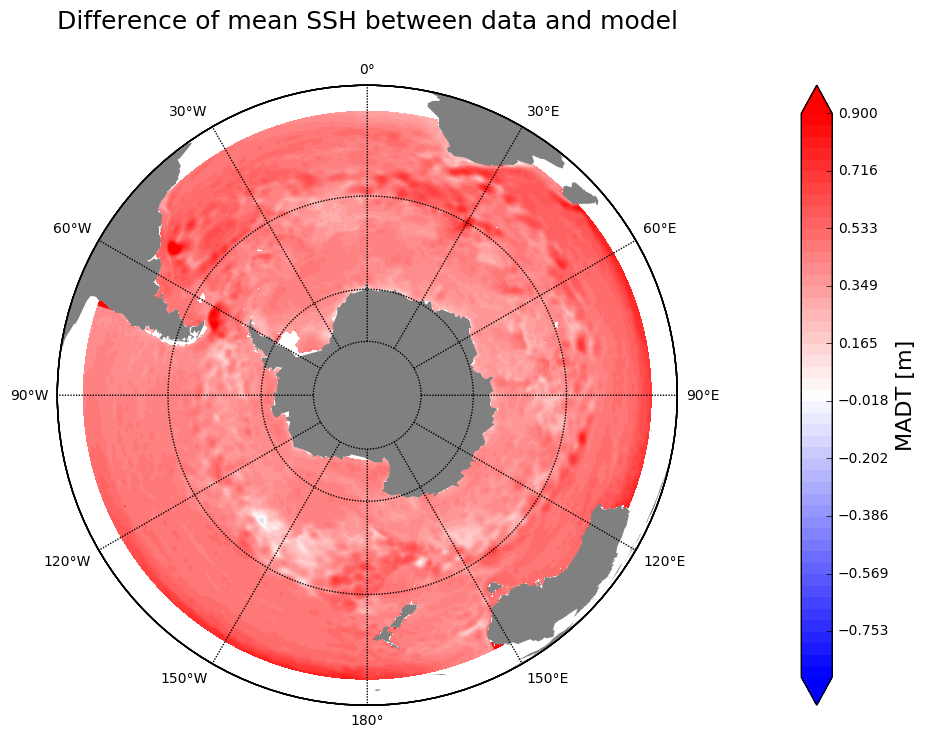

In [75]:
polar_map(np.linspace(-0.9, 0.9, 50), Xa, Ya, diff, 'Difference of mean SSH between data and model', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'diff_jup.png')

# Plot of the mean SSH of the model + difference between mean SSH of data and model

In [12]:
# Offset just at -66
print(mean_diff_weight)

0.783656


In [18]:
# Offset from -66 to -30
print(mean_diff_weight)

0.468579


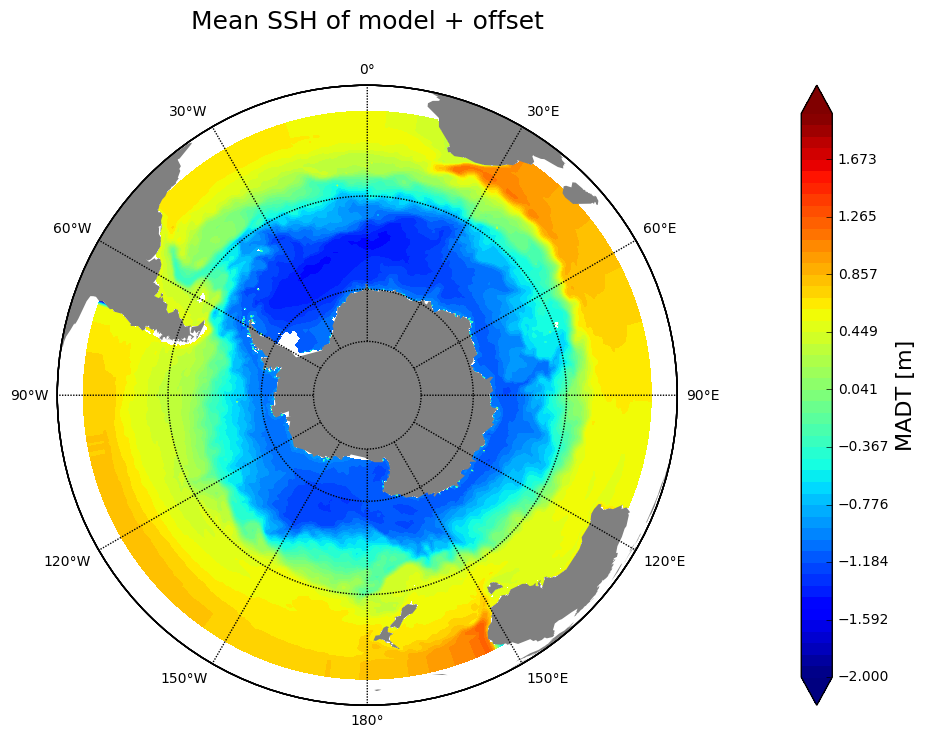

In [58]:
polar_map(np.linspace(-2,2,50), Xa, Ya, mean_ssh_model+mean_diff_weight, 'Mean SSH of model + offset', 'MADT [m]', plt.cm.jet, plot_path_jup, 'offset+model_jup.png')

# Plot of the difference of the mean SSH between the model and data - mean of this difference

v       = np.linspace(-0.5,0.5,50)
fig     = plt.figure(figsize=(10,10))
m       = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=-20,llcrnrlon=0,urcrnrlon=360)
xm, ym  = m(Xa, Ya)
im      = m.contourf(xm, ym, diff-mean_diff, levels=v, extend='both', cmap=plt.cm.bwr)

cbar = m.colorbar(im,pad='20%')
cbar.set_label('MADT [m]', fontsize =16)

m.drawcoastlines()
m.fillcontinents(color='0.5', lake_color='0.5')
m.drawparallels(np.arange(-90.,-30., 20.))
m.drawmeridians(np.arange(-180.,181.,60.))

plt.title("Mercator projection of difference of mean SSH between data and model - offset")
plt.show()

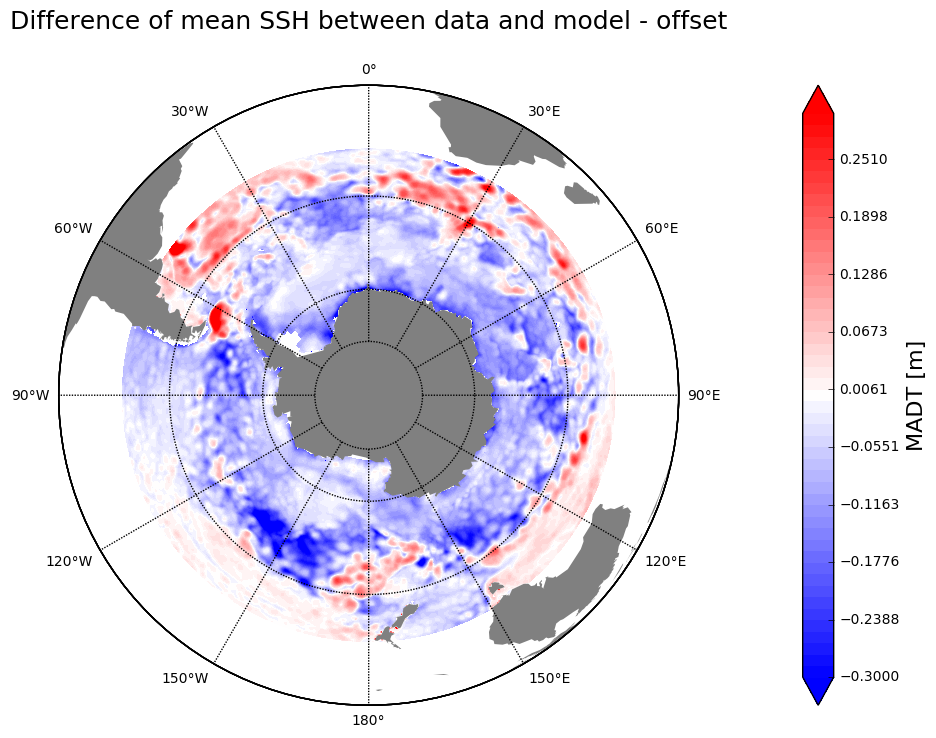

In [24]:
polar_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'diff-offset_bwr_jup.png')

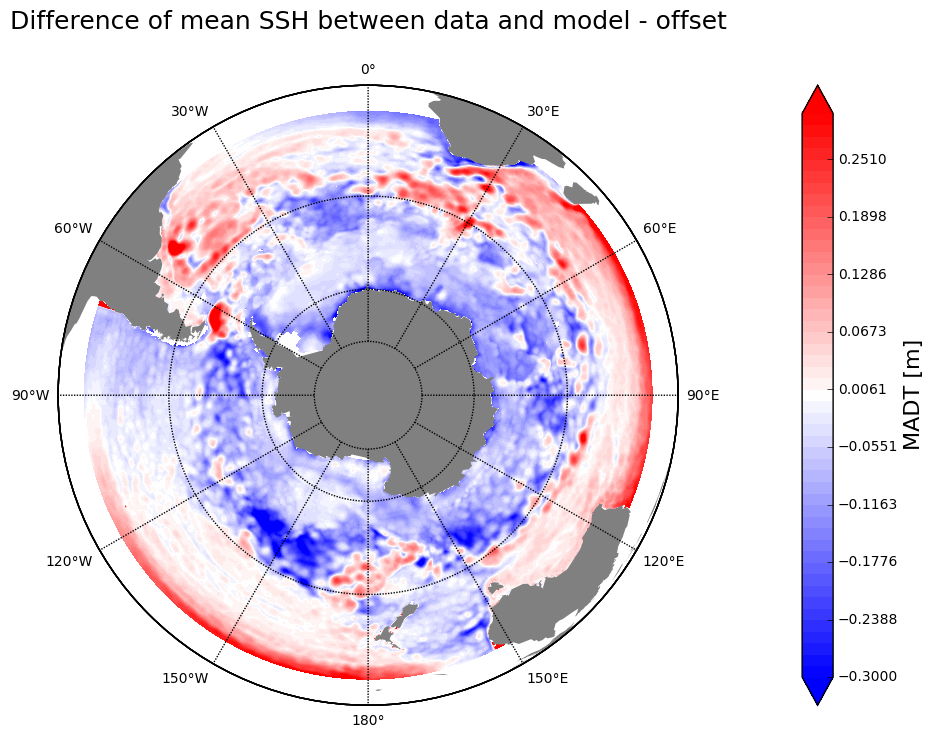

In [34]:
polar_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'diff-offset_bwr_jup.png')

In [23]:
def merc_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(12,12))
        m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-10.,\
                  llcrnrlon=120.,urcrnrlon=300.,lat_ts=-60.,resolution='c')
        #m       = Basemap(llcrnrlon=lon[0],llcrnrlat=-70.,urcrnrlon=lon[-1],urcrnrlat=lat[-1],\
        #          rsphere=(6378137.00,6356752.3142),\
        #          resolution='l',area_thresh=1000.,projection='lcc',\
        #          lat_1=-70.,lon_0=-185.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='k', lake_color='k')
        m.drawparallels(np.arange(-80.,-10.,10), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(120.,300.,30), labels=[0, 0, 0, 1])
        m.drawcoastlines()



        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

-30

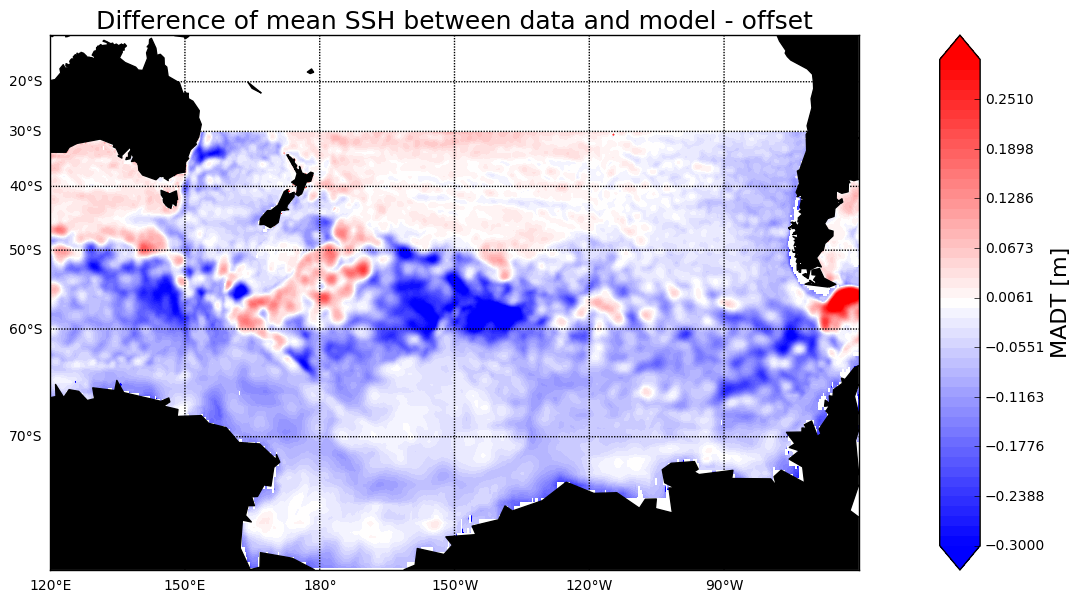

In [50]:
merc_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'fig1_rapport.png')

-40

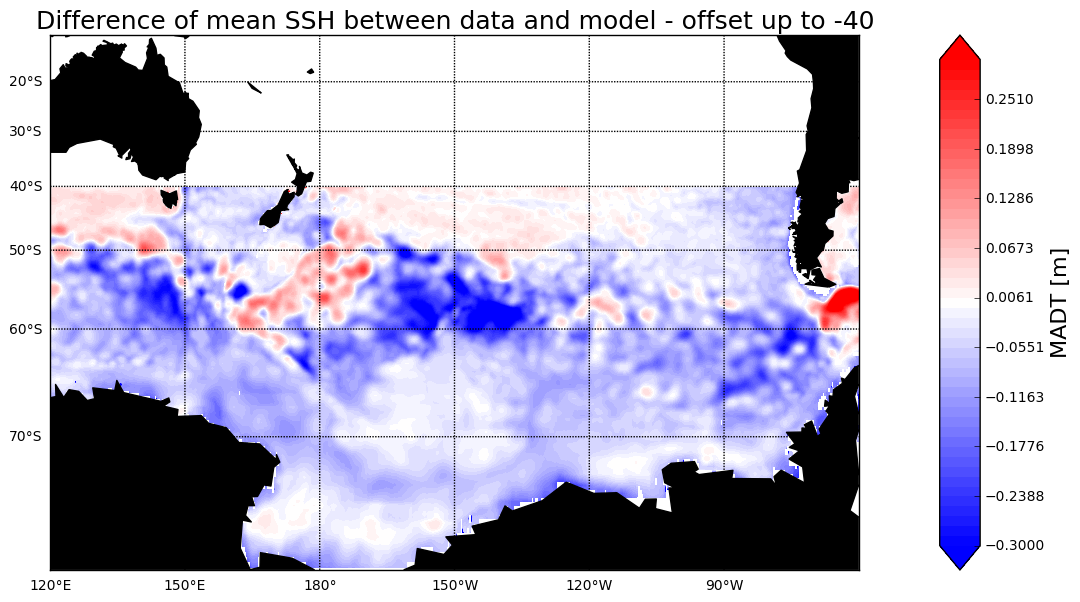

In [80]:
merc_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset up to -40', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'fig1_rapport.png')

In [88]:
(diff-mean_diff_weight).max()

0.52310342

In [89]:
(diff-mean_diff_weight).min()

-1.3939028

Different colorbar

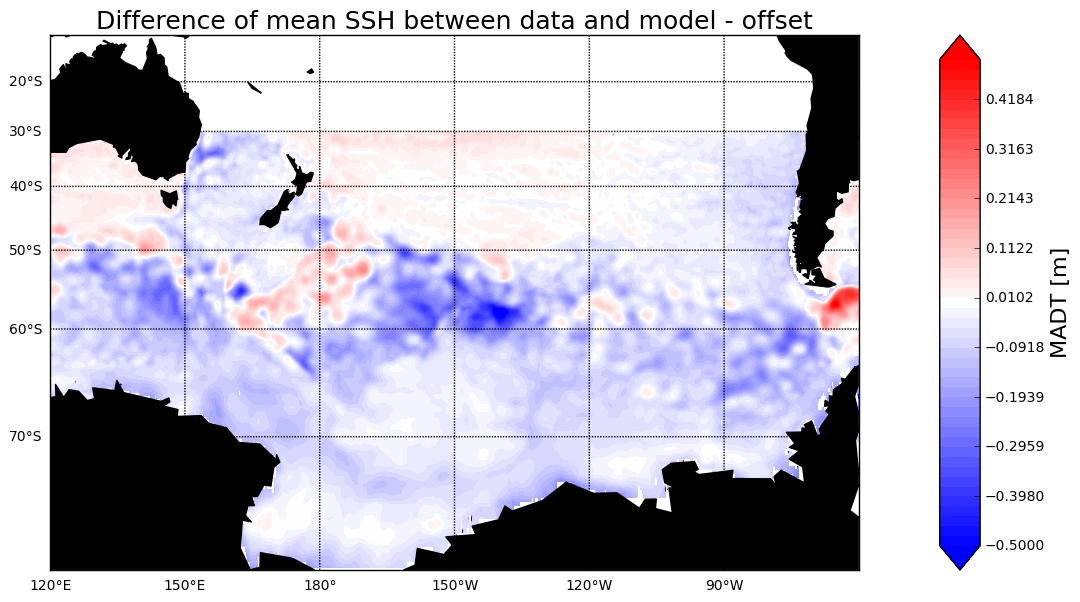

In [49]:
merc_map(np.linspace(-0.5,0.5,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'fig1_rapport.png')

/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


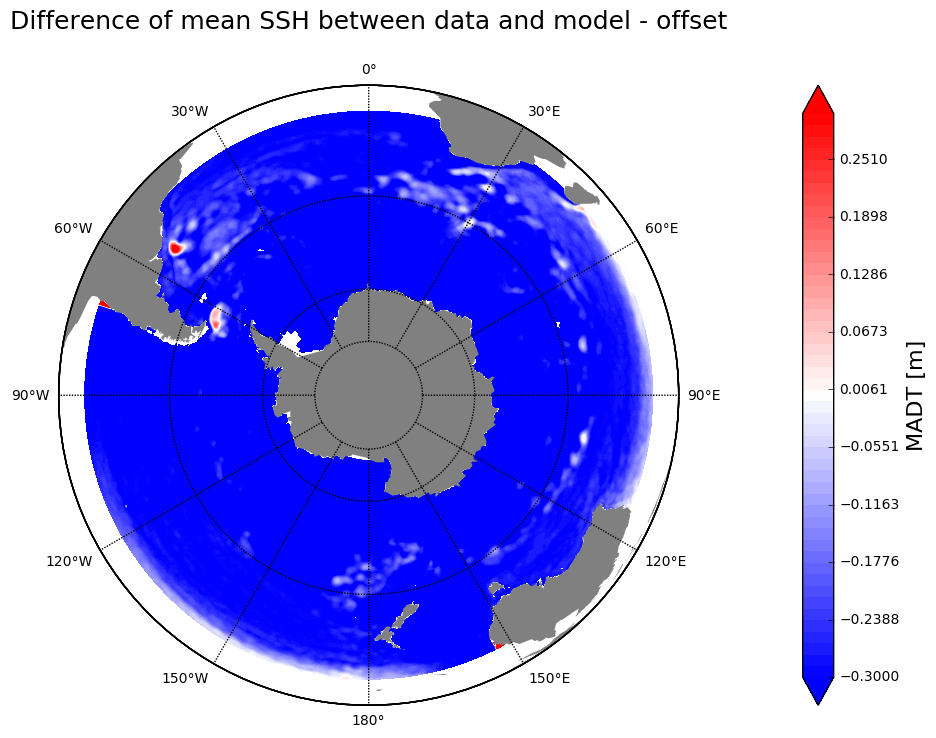

In [11]:
polar_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'diff-offset_bwr_jup.png')

In [30]:
D = diff-mean_diff_weight

In [33]:
print(D.min(), D.max(), np.mean(D))

(-1.7134621, 0.43216258, -0.36816666147884147)


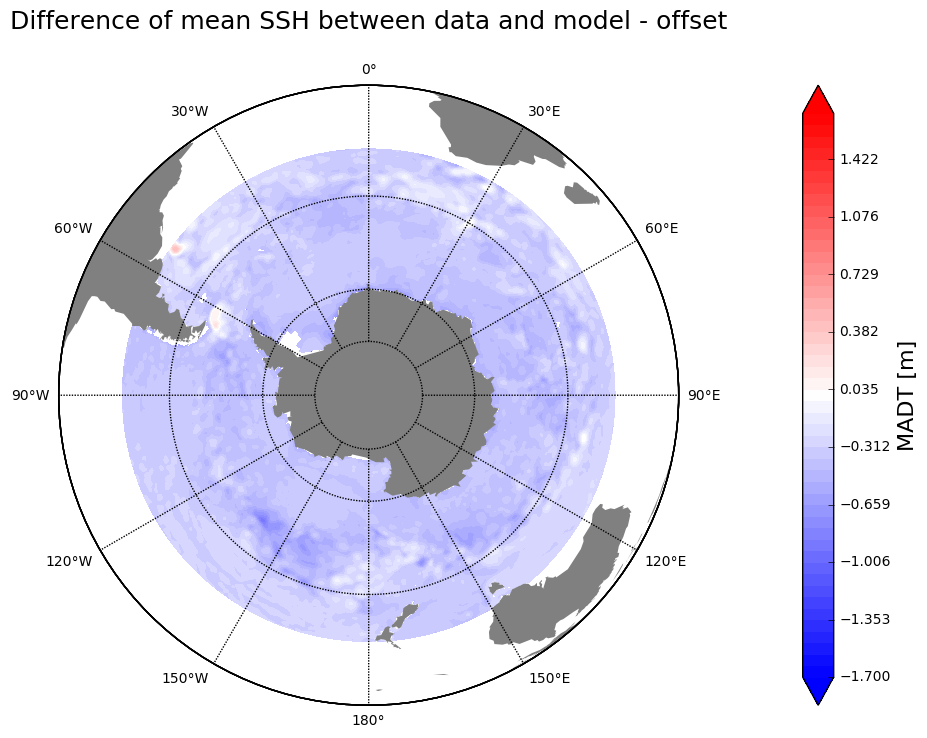

In [32]:
polar_map(np.linspace(-1.7,1.7,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'diff-offset_bwr_jup.png')

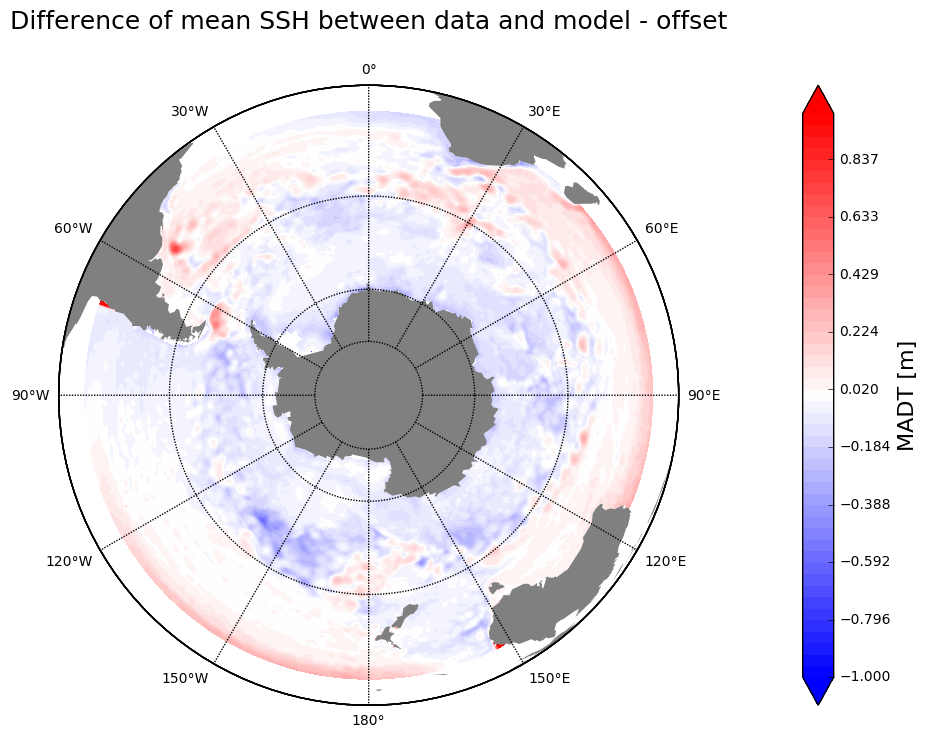

In [82]:
polar_map(np.linspace(-1,1,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'aviso-offset-model_jup.png')

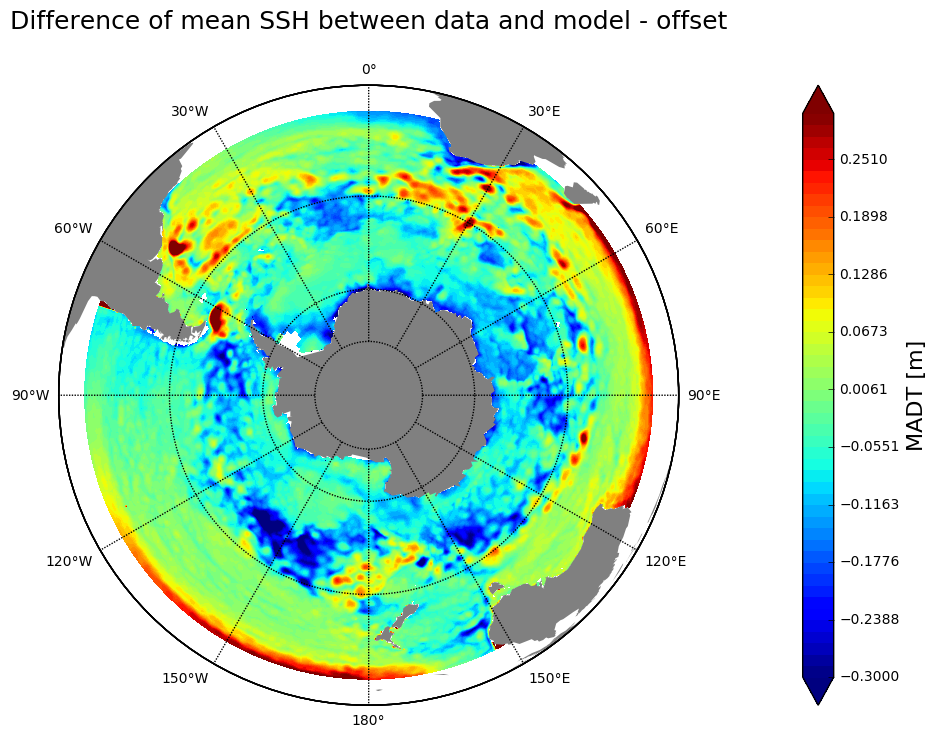

In [83]:
polar_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.jet, plot_path_jup, 'diff-offset_jet_jup.png')

# Plot of the difference of the mean SSH between the model and data - offset / standard deviation of AVISO

In [84]:
aa = (diff-mean_diff_weight)/std_aviso

In [85]:
aa.shape

(228, 1440)

In [86]:
print(aa.min(), aa.max(), np.mean(aa))

(-2204.614865461408, 68.22560315465465, -1.2885751062131523)


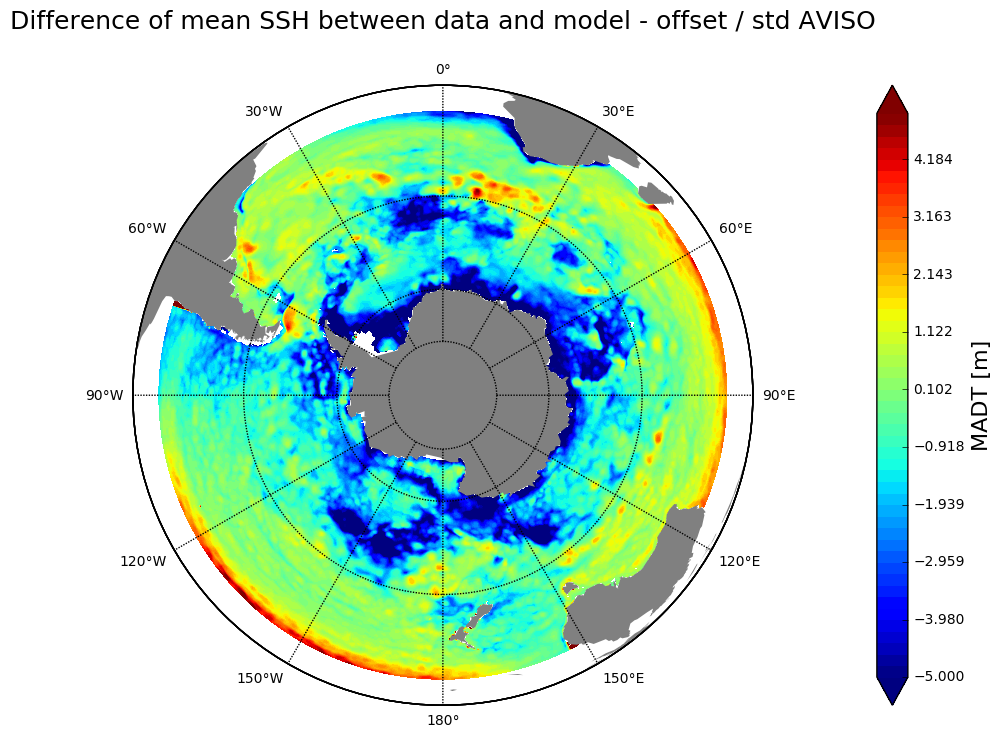

In [88]:
polar_map(np.linspace(-5,5,50), Xa, Ya, (diff-mean_diff_weight)/std_aviso, 'Difference of mean SSH between data and model - offset / std AVISO', 'MADT [m]', plt.cm.jet, plot_path_jup, 'diff-offset_std_aviso_jup.png')

# Plot of the difference of the mean SSH between the model and data / standard deviation of AVISO

In [95]:
bb = diff/std_aviso

In [96]:
print(bb.min(), bb.max(), np.mean(bb))

(-46.532035326144978, 8036.7715511887018, 9.8003323242465346)


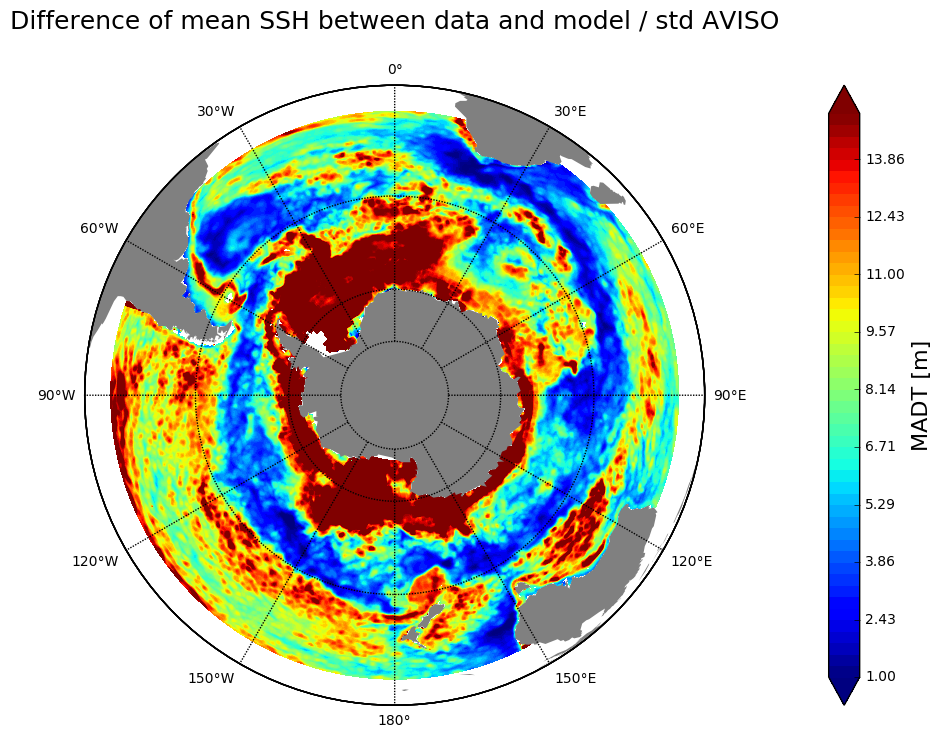

In [98]:
polar_map(np.linspace(1,15,50), Xa, Ya, diff/std_aviso, 'Difference of mean SSH between data and model / std AVISO', 'MADT [m]', plt.cm.jet, plot_path_jup, 'diff_std_aviso_jup.png')

# Profiles

Could change to those longitude instead to be consistant with the .125

In [72]:
xsave[840], xsave[720]

(210.125, 180.125)

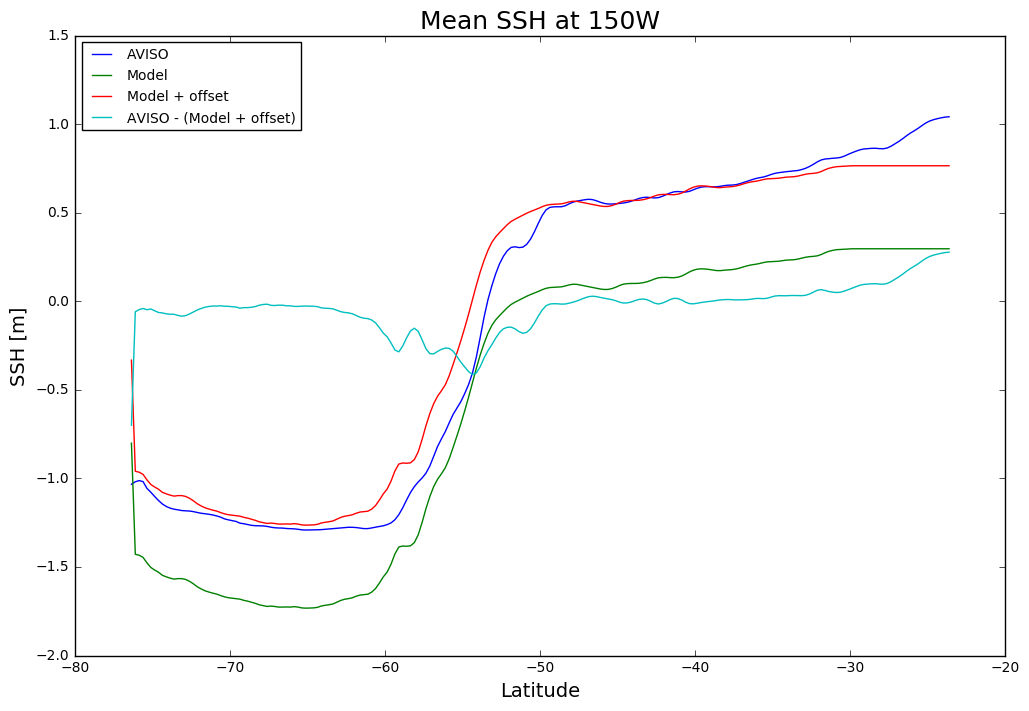

In [43]:
plt.figure(figsize=(12,8))
plt.plot(ysave, mean_ssh_aviso[:,841], label='AVISO')
plt.plot(ysave, mean_ssh_model[:,841], label='Model')
plt.plot(ysave, mean_ssh_model[:,841] + mean_diff_weight, label='Model + offset')
plt.plot(ysave, mean_ssh_aviso[:,841] - mean_ssh_model[:,841] - mean_diff_weight, label='AVISO - (Model + offset)')
plt.legend(loc='upper left', fontsize=10)
plt.title('Mean SSH at 150W', fontsize=18)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SSH [m]', fontsize=14)

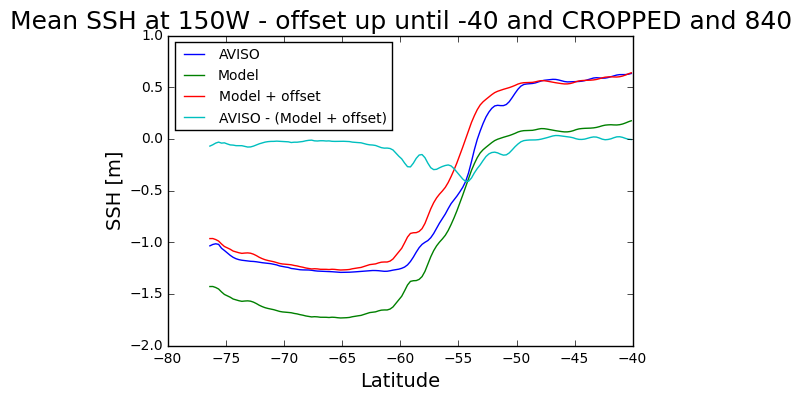

In [86]:
plt.figure()#figsize=(12,8))
plt.plot(ysave[:162], mean_ssh_aviso[:,840], label='AVISO')
plt.plot(ysave[:162], mean_ssh_model[:,840], label='Model')
plt.plot(ysave[:162], mean_ssh_model[:,840] + mean_diff_weight, label='Model + offset')
plt.plot(ysave[:162], mean_ssh_aviso[:,840] - mean_ssh_model[:,840] - mean_diff_weight, label='AVISO - (Model + offset)')
plt.legend(loc='upper left', fontsize=10)
plt.title('Mean SSH at 150W - offset up until -40 and CROPPED and 840', fontsize=18)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SSH [m]', fontsize=14)

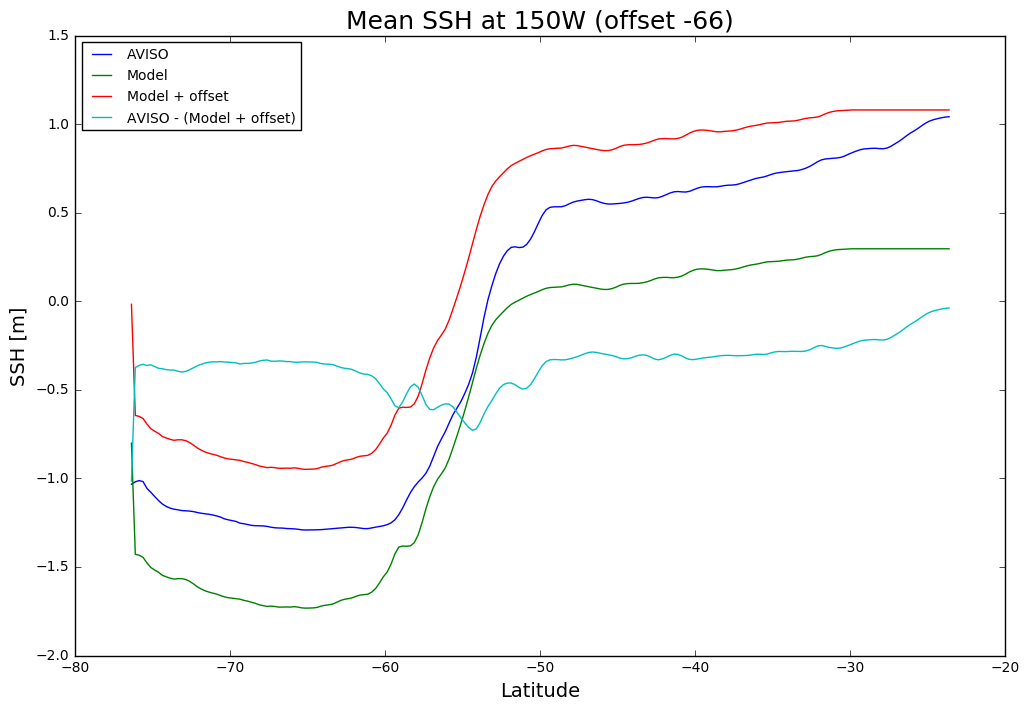

In [39]:
plt.figure(figsize=(12,8))
plt.plot(ysave, mean_ssh_aviso[:,841], label='AVISO')
plt.plot(ysave, mean_ssh_model[:,841], label='Model')
plt.plot(ysave, mean_ssh_model[:,841] + mean_diff_weight, label='Model + offset')
plt.plot(ysave, mean_ssh_aviso[:,841] - mean_ssh_model[:,841] - mean_diff_weight, label='AVISO - (Model + offset)')
plt.legend(loc='upper left', fontsize=10)
plt.title('Mean SSH at 150W (offset -66)', fontsize=18)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SSH [m]', fontsize=14)

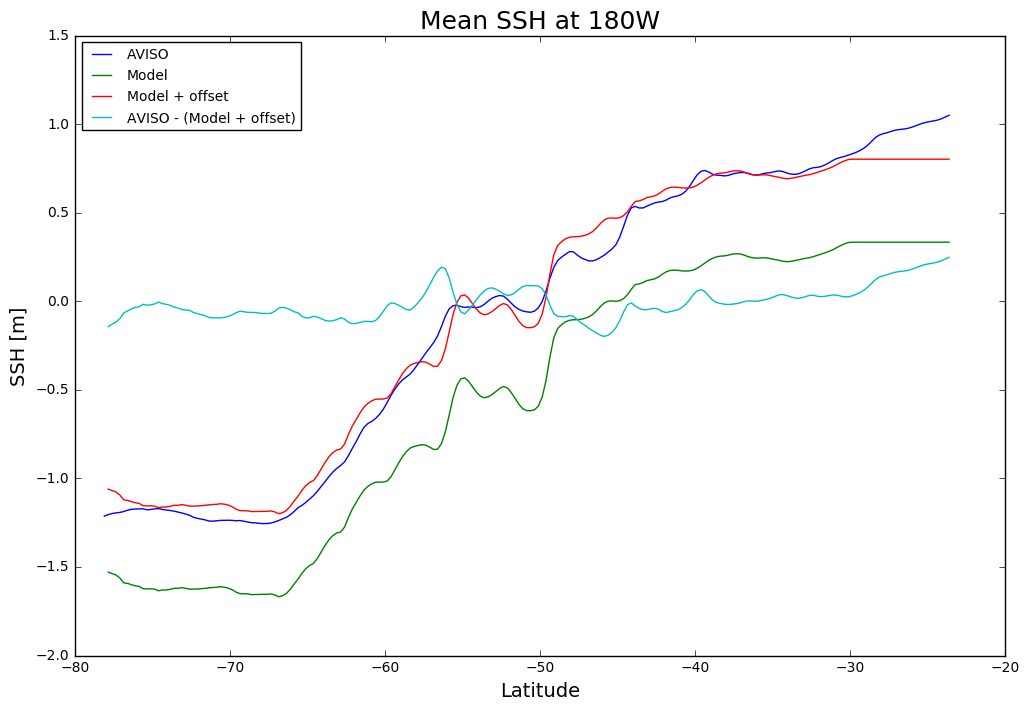

In [44]:
plt.figure(figsize=(12,8))
plt.plot(ysave, mean_ssh_aviso[:,721], label='AVISO')
plt.plot(ysave, mean_ssh_model[:,721], label='Model')
plt.plot(ysave, mean_ssh_model[:,721] + mean_diff_weight, label='Model + offset')
plt.plot(ysave, mean_ssh_aviso[:,721] - mean_ssh_model[:,721] - mean_diff_weight, label='AVISO - (Model + offset)')
plt.legend(loc='upper left', fontsize=10)
plt.title('Mean SSH at 180W', fontsize=18)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SSH [m]', fontsize=14)

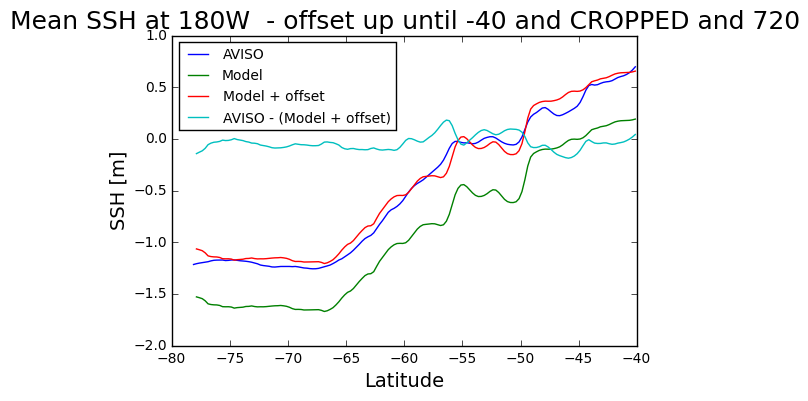

In [87]:
plt.figure()#figsize=(12,8))
plt.plot(ysave[:162], mean_ssh_aviso[:,720], label='AVISO')
plt.plot(ysave[:162], mean_ssh_model[:,720], label='Model')
plt.plot(ysave[:162], mean_ssh_model[:,720] + mean_diff_weight, label='Model + offset')
plt.plot(ysave[:162], mean_ssh_aviso[:,720] - mean_ssh_model[:,720] - mean_diff_weight, label='AVISO - (Model + offset)')
plt.legend(loc='upper left', fontsize=10)
plt.title('Mean SSH at 180W  - offset up until -40 and CROPPED and 720', fontsize=18)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SSH [m]', fontsize=14)

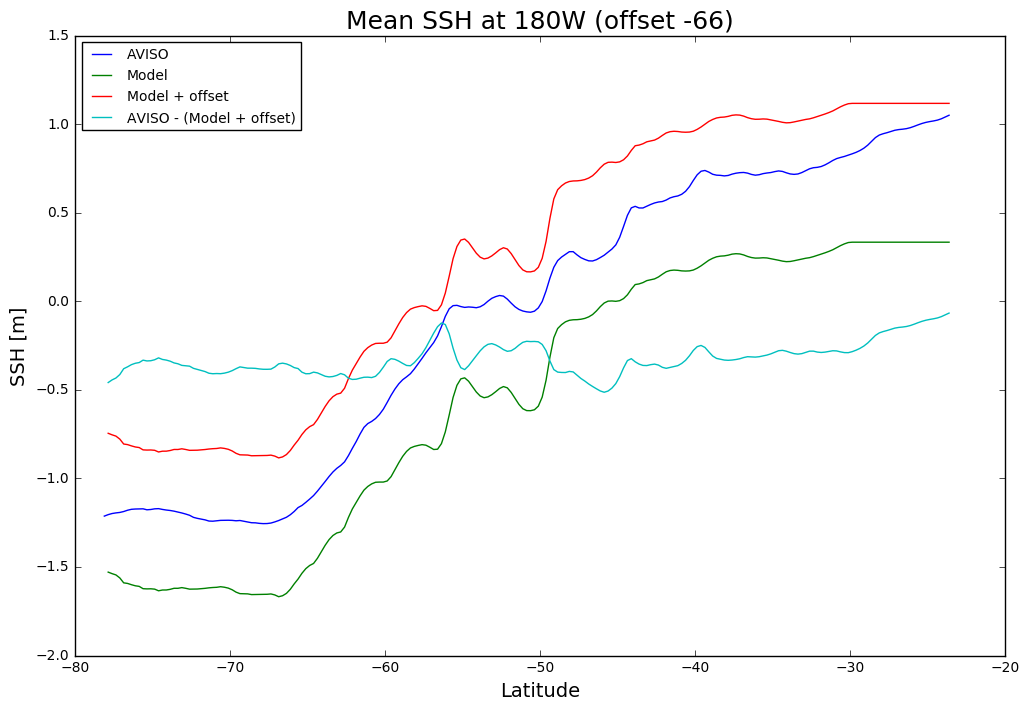

In [38]:
plt.figure(figsize=(12,8))
plt.plot(ysave, mean_ssh_aviso[:,721], label='AVISO')
plt.plot(ysave, mean_ssh_model[:,721], label='Model')
plt.plot(ysave, mean_ssh_model[:,721] + mean_diff_weight, label='Model + offset')
plt.plot(ysave, mean_ssh_aviso[:,721] - mean_ssh_model[:,721] - mean_diff_weight, label='AVISO - (Model + offset)')
plt.legend(loc='upper left', fontsize=10)
plt.title('Mean SSH at 180W (offset -66)', fontsize=18)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SSH [m]', fontsize=14)